# Prep work

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.models as models

import os
import numpy as np
import pandas as pd
from PIL import Image
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import albumentations as A
import albumentations.pytorch

In [2]:
# PARAMS
# transforms
presize = 256
crop = 244
# training
batch_size = 32
num_workers = 0
lr = 1e-2
momentum = 0.9
weight_decay = 3e-3
# num of epochs to train
frozen = 2 # only the last layer is trained
unfrozen = 4 # train everything
# lr scheduler
step_size = 4 # after this many epochs we will mult our lr by gamma
gamma = 0.1 # lr multiplier every step_size epochs

In [3]:
# settig up a device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# root path to the folder with images
root = r'data'

In [5]:
# building df by walking the image folders
df = pd.DataFrame(columns=['fname', 'label'])

car_fnames = []
car_labels = []

for path, _, filenames in os.walk(root):
    for filename in filenames:
        extension = filename.split('.')[-1]
        if extension!='jpg':
            continue

        car_fnames.append(os.path.join(path, filename))
        car_labels.append(path.split('\\')[-1])

df['fname'] = car_fnames
df['label'] = car_labels

print(f'shape of new df {df.shape}')

shape of new df (419, 2)


In [6]:
# encoding the labels
le = LabelEncoder()

df['encoded'] = le.fit_transform(df['label'].values)
df = df.drop('label', 1).rename(columns={'encoded':'label'})
df.head()

,fname,label
0,C:\Users\Oleg\Downloads\_CAR_IMAGES\data_1\HYU...,0
1,C:\Users\Oleg\Downloads\_CAR_IMAGES\data_1\HYU...,0
2,C:\Users\Oleg\Downloads\_CAR_IMAGES\data_1\HYU...,0
3,C:\Users\Oleg\Downloads\_CAR_IMAGES\data_1\HYU...,0
4,C:\Users\Oleg\Downloads\_CAR_IMAGES\data_1\HYU...,0


In [22]:
le.classes_

array(['HYUNDAI_Sonata_Silver', 'MERCEDES-BENZ_E 350_Black',
       'TOYOTA_Camry_Black', 'TOYOTA_Camry_White', 'TOYOTA_Prius_White'],
      dtype=object)

In [7]:
# transforms
train_transform = A.Compose([
        A.SmallestMaxSize(presize),
        A.RandomCrop(crop, crop),
        A.Normalize(),
        A.HorizontalFlip(),
        A.Rotate(limit=30),
        A.Cutout(),
        albumentations.pytorch.ToTensorV2()])

test_transform = A.Compose([
        A.SmallestMaxSize(presize),
        A.CenterCrop(crop, crop),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()])

In [8]:
# dataset class
class dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return (self.df.shape[0])

    def __getitem__(self, index):
        image = Image.open(self.df.fname[index]).convert('RGB')
        image = np.array(image)

        label = torch.tensor(self.df.label[index]).long()  

        if self.transform:
            augmentations = self.transform(image=image)
            image = augmentations['image']

        return image, label

# dfs, datasets, loaders

In [9]:
# get dfs by splitting
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1, shuffle=True)
# reset idx
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
# create dataset
train_dataset = dataset(train_df, train_transform)
test_dataset = dataset(test_df, test_transform)
# create loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True, 
                                            num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


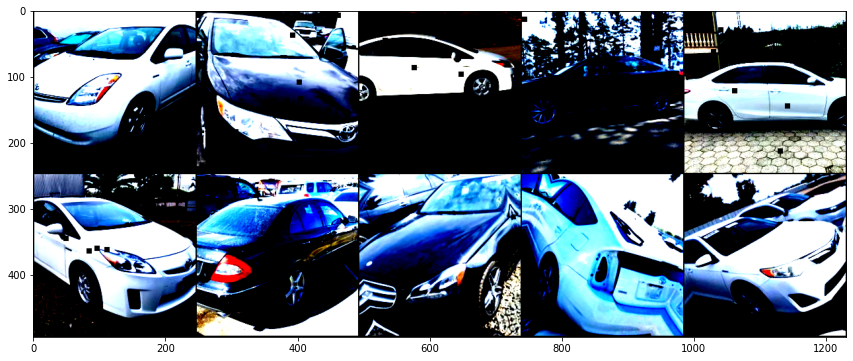

In [10]:
# displayig the data (looks this way because of normalization)
batch_tensor = next(iter(train_loader))[0][:10,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0)); # uncomment to show

In [11]:
# just a check if all is good with the shapes of the loaders
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(test_loader))[0].shape}')

dataloader test: torch.Size([32, 3, 244, 244]), torch.Size([32, 3, 244, 244])


# model setup, freezing the params

In [12]:
# load the pretrainded model
model = models.resnet18(pretrained=True)
# freeze all params
for param in model.parameters():
    param.requires_grad = False
# add new layer. It will NOT be freezed by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
# push the model to the device if available
model = model.to(device)

In [13]:
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# helper functions

In [14]:
# this is slightly modified roc_auc to handle multiclass problems (found on 'SO' and modified slightly)
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  # creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_list = []
  for per_class in unique_class:
    # creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    # marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    # using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_list.append(roc_auc)

  return np.mean(roc_auc_list)

In [15]:
# main train function
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                criterion=criterion,
                optimizer=optimizer, 
                lr_scheduler=lr_scheduler):

    print(f'================')
    print(f'started training...')

    for epoch in range(n_epochs):

        model.train()
        t0 = time.time()
        epoch_loss = 0

        for batch, (images, labels) in enumerate(train_loader):

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            epoch_loss += loss

            loss.backward()
            optimizer.step()

        epoch_time = round(time.time() - t0)

        lr_scheduler.step()
        test_loss, test_auc = test_model(model, test_loader)
        
        print(f'epoch: [{epoch+1}/{n_epochs}], train loss: {epoch_loss:.3f}, valid loss: {test_loss}, roc auc: {test_auc}, time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')

    return model

In [16]:
# function for validation or testing
def test_model(model=model, test_loader=test_loader):

    model.eval()
    epoch_loss = 0
    roc_auc = 0

    with torch.no_grad():

        for batch, (images, labels) in enumerate(test_loader):

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            epoch_loss += loss
            roc_auc += roc_auc_score_multiclass(labels, preds)

    avg_epoch_loss = round(float(epoch_loss / len(test_loader)), 3)
    avg_roc_auc = round(float(roc_auc / len(test_loader)), 3)

    return avg_epoch_loss, avg_roc_auc

In [17]:
# unfreeze all the params for training
def unfreeze(model=model):
    for param in model.parameters():
        param.requires_grad = True
    return model

# training the model

In [18]:
# train for a few epochs with frozen weights, unfreeze all weights and train again for a few more
start_time = time.time()

train_model(frozen)
unfreeze()
train_model(unfrozen)

total_time = time.time() - start_time
print(f'train time: {total_time//60:.0f}m {total_time%60:.0f}s')

started training...
epoch: [1/2], train loss: 18.931, valid loss: 1.559, roc auc: 0.582, time: 0m 17s
epoch: [2/2], train loss: 12.259, valid loss: 0.686, roc auc: 0.827, time: 0m 21s
started training...
epoch: [1/4], train loss: 6.191, valid loss: 0.326, roc auc: 0.915, time: 1m 3s
epoch: [2/4], train loss: 2.586, valid loss: 0.174, roc auc: 0.956, time: 1m 4s
epoch: [3/4], train loss: 0.945, valid loss: 0.108, roc auc: 0.984, time: 1m 3s
epoch: [4/4], train loss: 0.451, valid loss: 0.108, roc auc: 0.964, time: 1m 3s
train time: 5m 28s


In [20]:
# heavily overfits, but the dataset is tiny ~400 images

In [21]:
# saving the model
# checkpoint = {'model': model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, 'checkpoint.pth')

In [19]:
print('all done.')

all done.
